# MMAE project

-----
#### Imports

In [1]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE, Isomap, MDS

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import stack
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_probability as tfp

import seaborn as sns
sns.set()

from PIL import Image

3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]


--------
#### Imports data

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
print(os.listdir())
path = "drive/MyDrive/idsc"

os.chdir(path)
os.listdir()

['.config', 'drive', 'sample_data']


['All_images.npy', 'All_dof_fluctuations.npy', 'my_model_dof', 'model.png']

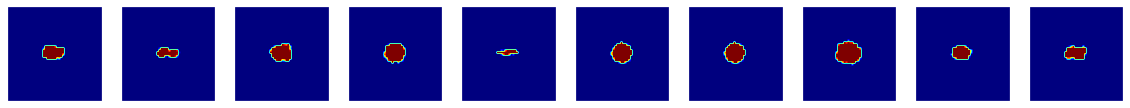

In [4]:
image_2D_defects = np.load('All_images.npy')
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(image_2D_defects[i],cmap='jet')
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [5]:
image_o = np.load('All_dof_fluctuations.npy').reshape(4000,48,48,6)
image_mechanics = np.vstack((image_o[:,:,:,0],image_o[:,:,:,1],image_o[:,:,:,2],image_o[:,:,:,3],image_o[:,:,:,4],image_o[:,:,:,5]))
#image_mechanics = image_o[:,:,:,0]
image_mechanics = np.expand_dims(image_mechanics, axis = 3)

In [6]:
print(image_mechanics.shape)

(24000, 48, 48, 1)


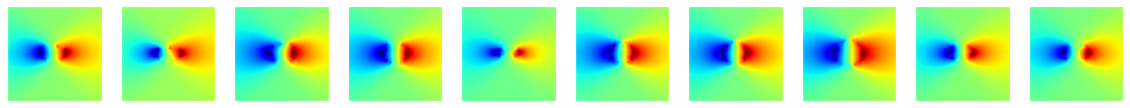

In [7]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(image_mechanics[i,:,:,0],cmap='jet')
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 1. Work on 2 separated autoencoders for each mode

Starting with a simple autoencoder with 2 convlutionnal nodes. Based on previous work we updated the activation function with a linear function in the decoder.

We added a Dropout layer to avoid overfitting

In [8]:
class AutoEncoder_defects1:
    
    def __init__(self, shape, filters=16, latent_dim=2, lr=0.0006, verbose=True):
        """
        Autoencoder for grey level images.

        Arguments:
            shape: shape of the input image [size_x, size_y, 1]
            filters: number of filters of the first conv layer
            latent_dim = size of the latent space (dimensions of the reduced space)
            lr: learning rate
            verbose = Boolean, if True, will print information about the models
        """
        
        self.input_shape = shape
        self.latent_dim = latent_dim
        self.verbose = verbose

        # Build the Autoencoder Model
        layer_filters = [filters, filters*2]

        # First build the Encoder Model
        inputs = Input(shape=self.input_shape, name='encoder_input')
        x = inputs
        # Stack of Conv2D blocks
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=1,
                        activation='relu',
                        padding='same')(x)
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
            x = Dropout(0.1, input_shape = (self.input_shape,))(x)

        # Shape info needed to build Decoder Model
        last_shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(self.latent_dim)(x)

        # Instantiate Encoder Model
        self.encoder = Model(inputs, latent)
        if self.verbose:
            self.encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,))
        x = Dense(last_shape[1] * last_shape[2] * last_shape[3])(latent_inputs)
        x = Reshape((last_shape[1], last_shape[2], last_shape[3]))(x)

        # Stack of Transposed Conv2D blocks
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=3,
                                strides=2,
                                activation='linear',
                                padding='same')(x)
            x = Conv2D(filters=filters,
                                kernel_size=3,
                                strides=1,
                                activation='linear',
                                padding='same')(x)                            

        # The activation of the output layer is a sigmoid, so that output values
        # are in the same range as input values
        outputs = Conv2D(filters=1,
                        kernel_size=3,
                        strides=1,
                        activation='sigmoid',
                        padding='same')(x)

        # Instantiate Decoder Model
        self.decoder = Model(latent_inputs, outputs)
        if self.verbose:
            self.decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        self.autoencoder = Model(inputs, 
                                self.decoder(self.encoder(inputs)),
                                name='autoencoder')
        if self.verbose:
            self.autoencoder.summary()
        
        ## Compile it with an appropriate loss function
        loss_ = 'mse' #loss_jaccard #'mse'
        self.autoencoder.compile(optimizer=Adam(learning_rate=lr), loss=loss_)
        self.autoencoder.summary()
        
    def fit(self, data, epochs, batch_size, validation_split=0.2):
        return self.autoencoder.fit(x=data, 
                             y=data, 
                             validation_split=validation_split,
                             shuffle=True, 
                             epochs=epochs, 
                             batch_size=batch_size)

    def predict(self, batch):
        """Autoencode batch of images"""
        return self.autoencoder.predict(batch)

    def save(self, path):
      self.autoencoder.save(path + '/my_autoencoder')
      self.encoder.save(path + '/my_encoder')
      self.decoder.save(path + '/my_decoder')

    def load_model(self, path):
      self.autoencoder = load_model(path + '/my_autoencoder')
      self.encoder = load_model(path + '/my_encoder')
      self.decoder = load_model(path + '/my_decoder')

-----
setting train, test batches

In [9]:
N = image_2D_defects.shape[0]
coeff = 0.2

N_split = int(N*(1-coeff))

x = image_2D_defects

x_train = x[:N_split]
x_test = x[N_split:]

In [10]:
### scaling
x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)
im = np.expand_dims(image_2D_defects, axis = 3)
x_min= x_train.min()
x_max= x_train.max()
x_train = (x_train-x_min)/(x_max-x_min)
x_test = (x_test-x_min)/(x_max-x_min)

In [11]:
LATENT_DIM = 50

shape = x_train.shape[1:4]
ae_defects = AutoEncoder_defects1(shape, filters=16, latent_dim=LATENT_DIM, lr=1.e-4, verbose=False)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 48, 48, 1)]       0         
                                                                 
 model (Functional)          (None, 50)                246818    
                                                                 
 model_1 (Functional)        (None, 48, 48, 1)         260593    
                                                                 
Total params: 507,411
Trainable params: 507,411
Non-trainable params: 0
_________________________________________________________________


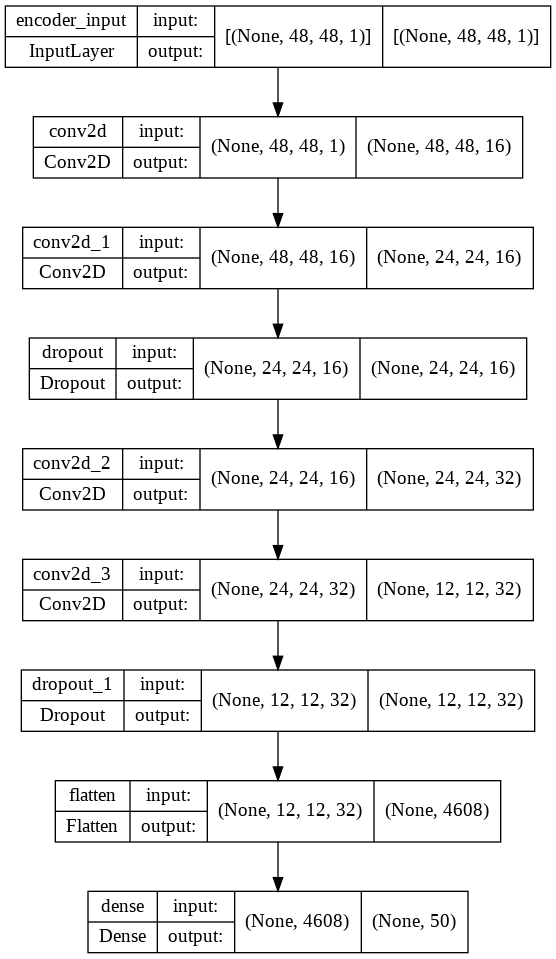

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(ae_defects.encoder, show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 150 #150
batch_size = 64 #128
history = ae_defects.fit(x_train, epochs, batch_size, validation_split=0.2)

Epoch 1/150
40/40 [==============================] - 1s 20ms/step - loss: 0.2417 - val_loss: 0.2215
Epoch 2/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0818 - val_loss: 0.0100
Epoch 3/150
40/40 [==============================] - 1s 13ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 4/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 5/150
40/40 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 6/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 7/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 8/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0028

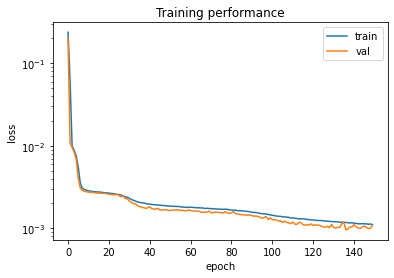

In [ ]:
plt.semilogy(history.epoch, history.history['loss'], label='train')
plt.semilogy(history.epoch, history.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### version 2 avec tanh en fonction d'activation

In [13]:
class AutoEncoder_defects2:
    
    def __init__(self, shape, filters=16, latent_dim=2, lr=0.0006, verbose=True):
        """
        Autoencoder for grey level images.

        Arguments:
            shape: shape of the input image [size_x, size_y, 1]
            filters: number of filters of the first conv layer
            latent_dim = size of the latent space (dimensions of the reduced space)
            lr: learning rate
            verbose = Boolean, if True, will print information about the models
        """
        
        self.input_shape = shape
        self.latent_dim = latent_dim
        self.verbose = verbose

        # Build the Autoencoder Model
        layer_filters = [filters, filters*2]

        # First build the Encoder Model
        inputs = Input(shape=self.input_shape, name='encoder_input')
        x = inputs
        # Stack of Conv2D blocks
        for filters in layer_filters:
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=1,
                        activation='tanh',
                        padding='same')(x)
            x = Conv2D(filters=filters,
                        kernel_size=3,
                        strides=2,
                        activation='tanh',
                        padding='same')(x)
            x = Dropout(0.1, input_shape = (self.input_shape,))(x)

        # Shape info needed to build Decoder Model
        last_shape = K.int_shape(x)

        # Generate the latent vector
        x = Flatten()(x)
        latent = Dense(self.latent_dim)(x)

        # Instantiate Encoder Model
        self.encoder = Model(inputs, latent)
        if self.verbose:
            self.encoder.summary()

        # Build the Decoder Model
        latent_inputs = Input(shape=(latent_dim,))
        x = Dense(last_shape[1] * last_shape[2] * last_shape[3])(latent_inputs)
        x = Reshape((last_shape[1], last_shape[2], last_shape[3]))(x)

        # Stack of Transposed Conv2D blocks
        for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters,
                                kernel_size=3,
                                strides=2,
                                activation='tanh',
                                padding='same')(x)
            x = Conv2D(filters=filters,
                                kernel_size=3,
                                strides=1,
                                activation='tanh',
                                padding='same')(x)                            

        # The activation of the output layer is a sigmoid, so that output values
        # are in the same range as input values
        outputs = Conv2D(filters=1,
                        kernel_size=3,
                        strides=1,
                        activation='sigmoid',
                        padding='same')(x)

        # Instantiate Decoder Model
        self.decoder = Model(latent_inputs, outputs)
        if self.verbose:
            self.decoder.summary()

        # Autoencoder = Encoder + Decoder
        # Instantiate Autoencoder Model
        self.autoencoder = Model(inputs, 
                                self.decoder(self.encoder(inputs)),
                                name='autoencoder')
        if self.verbose:
            self.autoencoder.summary()
        
        ## Compile it with an appropriate loss function
        loss_ = 'mse' #loss_jaccard #'mse'
        self.autoencoder.compile(optimizer=Adam(learning_rate=lr), loss=loss_)
        self.autoencoder.summary()
        
    def fit(self, data, epochs, batch_size, validation_split=0.2):
        return self.autoencoder.fit(x=data, 
                             y=data, 
                             validation_split=validation_split,
                             shuffle=True, 
                             epochs=epochs, 
                             batch_size=batch_size)

    def predict(self, batch):
        """Autoencode batch of images"""
        return self.autoencoder.predict(batch)

    def save(self, path):
      self.autoencoder.save(path + '/my_autoencoder')
      self.encoder.save(path + '/my_encoder')
      self.decoder.save(path + '/my_decoder')

    def load_model(self, path):
      self.autoencoder = load_model(path + '/my_autoencoder')
      self.encoder = load_model(path + '/my_encoder')
      self.decoder = load_model(path + '/my_decoder')

In [14]:
LATENT_DIM = 50

shape = x_train.shape[1:4]
ae_defects2 = AutoEncoder_defects2(shape, filters=16, latent_dim=LATENT_DIM, lr=1.e-4, verbose=False)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 48, 48, 1)]       0         
                                                                 
 model_2 (Functional)        (None, 50)                246818    
                                                                 
 model_3 (Functional)        (None, 48, 48, 1)         260593    
                                                                 
Total params: 507,411
Trainable params: 507,411
Non-trainable params: 0
_________________________________________________________________


In [25]:
epochs = 150 #150
batch_size = 64 #128
history2 = ae_defects2.fit(x_train, epochs, batch_size, validation_split=0.2)

Epoch 1/150
40/40 [==============================] - 2s 21ms/step - loss: 0.2209 - val_loss: 0.1080
Epoch 2/150
40/40 [==============================] - 1s 15ms/step - loss: 0.0256 - val_loss: 0.0108
Epoch 3/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 4/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 5/150
40/40 [==============================] - 1s 15ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 6/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 7/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 8/150
40/40 [==============================] - 1s 14ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/150
40/40 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/150
40/40 [==============================] - 1s 15ms/step - loss: 0.0030 - val_loss: 0.0030

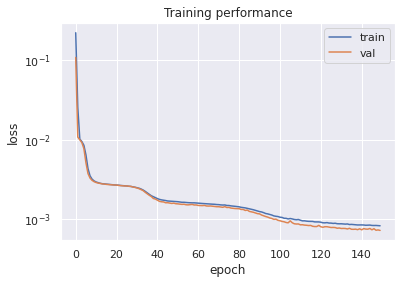

In [26]:
plt.semilogy(history2.epoch, history2.history['loss'], label='train')
plt.semilogy(history2.epoch, history2.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

We keep the tanh function as results seem better

In [ ]:
dims_latent = [10, 40, 50, 60, 100, 200]
histories = []
for dim in dims_latent:
  ae = AutoEncoder_defects2(shape, filters=16, latent_dim=dim, lr=1.e-4, verbose=False)
  epochs = 150 #150
  batch_size = 64 #128
  history = ae.fit(x_train, epochs, batch_size, validation_split=0.2)
  histories.append(history)


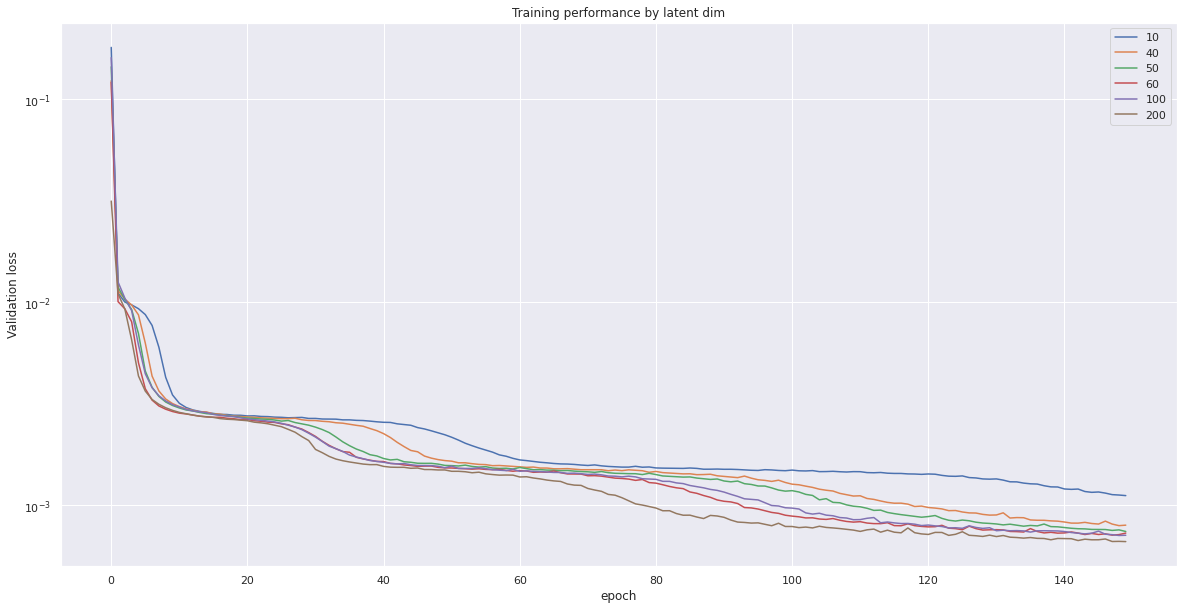

In [ ]:
plt.figure(figsize = (20,10))

for i, history in enumerate(histories):
  plt.semilogy(history.epoch, history.history['val_loss'], label=f"{dims_latent[i]}")
plt.title('Training performance by latent dim')
plt.ylabel('Validation loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

We are keeping dim  = 60 is great as it allows fast convergence in a pretty low time.

In [ ]:
filter_nb = [5, 10, 12, 16, 20, 40]
histories = []
for filt in filter_nb:
  ae = AutoEncoder_defects2(shape, filters=filt, latent_dim=60, lr=1.e-4, verbose=False)
  epochs = 150 #150
  batch_size = 64 #128
  history = ae.fit(x_train, epochs, batch_size, validation_split=0.2)
  histories.append(history)

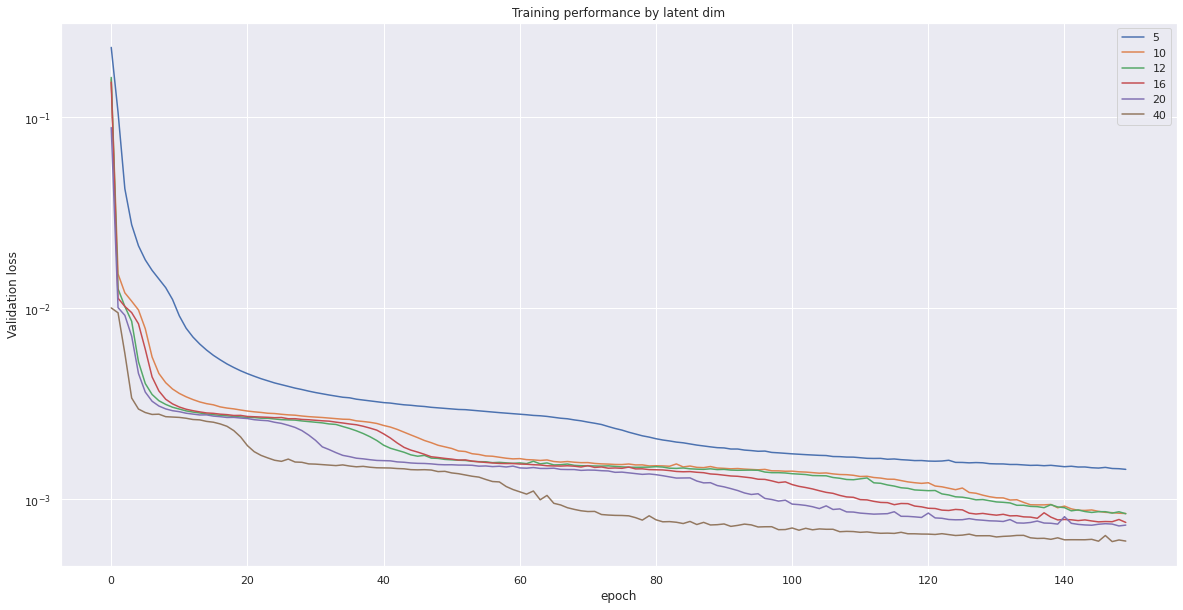

In [ ]:
plt.figure(figsize = (20,10))

for i, history in enumerate(histories):
  plt.semilogy(history.epoch, history.history['val_loss'], label=f"{filter_nb[i]}")
plt.title('Training performance by latent dim')
plt.ylabel('Validation loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

We are keeping 20 filters as it converges way faster than 16 and in a similar duration. 

The learning rate est correct (assez haut et pas trop d'instabilité), nous allons garder celui la

## Final AE for Defects

In [15]:
ae_final = AutoEncoder_defects2(shape, filters=20, latent_dim=60, lr=1.e-4, verbose=False)


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 48, 48, 1)]       0         
                                                                 
 model_4 (Functional)        (None, 60)                371160    
                                                                 
 model_5 (Functional)        (None, 48, 48, 1)         391261    
                                                                 
Total params: 762,421
Trainable params: 762,421
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs = 1500 #150
batch_size = 64 #128
history2 = ae_final.fit(x_train, epochs, batch_size, validation_split=0.2)

Epoch 1/1500
40/40 [==============================] - 3s 23ms/step - loss: 0.2145 - val_loss: 0.0720
Epoch 2/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0181 - val_loss: 0.0103
Epoch 3/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 4/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 5/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 6/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 7/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 8/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.0029 - val_lo

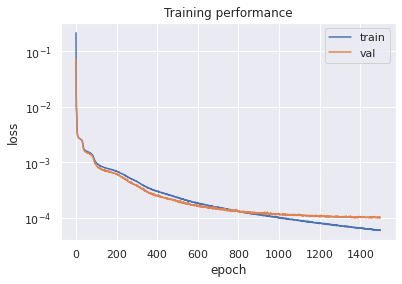

In [18]:
plt.semilogy(history2.epoch, history2.history['loss'], label='train')
plt.semilogy(history2.epoch, history2.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

a bit of overfitting after 900 epochs.

In [21]:
ae_final = AutoEncoder_defects2(shape, filters=20, latent_dim=60, lr=1.e-4, verbose=False)
epochs = 800 #150
batch_size = 64 #128
history2 = ae_final.fit(x_train, epochs, batch_size, validation_split=0.2)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 48, 48, 1)]       0         
                                                                 
 model_6 (Functional)        (None, 60)                371160    
                                                                 
 model_7 (Functional)        (None, 48, 48, 1)         391261    
                                                                 
Total params: 762,421
Trainable params: 762,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
40/40 [==============================] - 2s 24ms/step - loss: 0.1984 - val_loss: 0.0365
Epoch 2/800
40/40 [==============================] - 1s 18ms/step - loss: 0.0129 - val_loss: 0.0099
Epoch 3/800
40/40 [==============================] - 1s 19ms/step - loss: 0.0094 - val_loss: 0.0091
Epoch 4/800
4

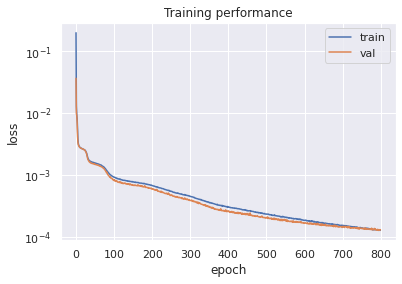

In [22]:
plt.semilogy(history2.epoch, history2.history['loss'], label='train')
plt.semilogy(history2.epoch, history2.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [23]:
ae_final.save('model_final_defects')